In [1]:
import multiprocessing
import random
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from src.environments import WirelessCommunicationsEnv
from src.utils import Discretizer
from src.sampler import PendulumTrajectorySampler, EpsilonGreedyPendulumTrajectorySampler
from src.trainer import QNetworkTrainer, QNetworkTester
from src.models import PARAFAC

In [2]:
H = 50

In [3]:
lbus = [1.0, 0.9, 0.2, 0.0]
ts = [20.0, 20.0, 10.0, 10.0]
b_harv = [1.0, 1.0, 0.2, 0.2]
autocorr = [0.1, 0.1, 0.7, 0.7]
occs = [
    np.array([
        [0.2, 0.8],
        [0.8, 0.2],
    ]),
    np.array([
        [0.3, 0.7],
        [0.7, 0.3],
    ]),
    np.array([
        [0.7, 0.3],
        [0.3, 0.7],
    ]),
    np.array([
        [0.8, 0.2],
        [0.2, 0.8],
    ])
]

envs = [WirelessCommunicationsEnv(
    T=H,
    K=1,
    snr_max=10,
    snr_min=10,
    snr_autocorr=autocorr[i],
    P_occ=occs[i],
    occ_initial=[1],
    batt_harvest=b_harv[i], 
    P_harvest=0.2, 
    batt_initial=10,
    batt_max_capacity=5,
    batt_weight=1.0, 
    queue_initial=10,
    queue_arrival=3,
    queue_max_capacity=20,
    t_queue_arrival=ts[i],
    queue_weight=0.3, # 0.2
    loss_busy=lbus[i],  
) for i in range(len(lbus))]

In [4]:
discretizer = Discretizer(
    min_points_states=[0, 0, 0, 0],
    max_points_states=[20, 1, 20, 5],
    bucket_states=[20, 2, 20, 10],
    min_points_actions=[0],
    max_points_actions=[2],
    bucket_actions=[10],
)

In [5]:
nS = [20, 2, 20, 10]
nA = [10]
nT = len(lbus)
gamma = 0.99

In [6]:
def create_target(states_next, rewards, Q, tasks=None):
    if tasks is not None:
        idx_target = torch.cat((tasks.unsqueeze(1), states_next), dim=1)
    else:
        idx_target = states_next

    with torch.no_grad():
        q_target = rewards + gamma * Q(idx_target).max(dim=1).values

    return q_target

def create_idx_hat(states, actions, tasks=None):
    if tasks is not None:
        idx_hat = torch.cat((tasks.unsqueeze(1), states, actions), dim=1)
    else:
        idx_hat = torch.cat((states, actions), dim=1)
    return idx_hat

def update_model(s_idx, sp_idx, a_idx, r, Q, opt, tasks=None):
    for factor in Q.factors:
        q_target = create_target(sp_idx, r, Q, tasks)
        idx_hat = create_idx_hat(s_idx, a_idx, tasks)
        q_hat = Q(idx_hat)

        opt.zero_grad()
        loss = torch.nn.MSELoss()(q_hat, q_target)
        loss.backward()

        with torch.no_grad():
            for frozen_factor in Q.factors:
                if frozen_factor is not factor:
                    frozen_factor.grad = None

        opt.step()

def select_random_action() -> np.ndarray:
        a_idx = tuple(np.random.randint(discretizer.bucket_actions).tolist())
        return discretizer.get_action_from_index(a_idx), a_idx

def select_greedy_action(Q, s_idx: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        a_idx_flat = Q(s_idx).argmax().detach().item()
        a_idx = np.unravel_index(a_idx_flat, discretizer.bucket_actions)
        return discretizer.get_action_from_index(a_idx), a_idx

def select_action(Q, s_idx: np.ndarray, epsilon: float) -> np.ndarray:
    if np.random.rand() < epsilon:
        return select_random_action()
    return select_greedy_action(Q, s_idx)

# Mono-task

In [7]:
E = 3000
lr = 0.01
eps = 1.0
eps_decay = 0.9999
eps_min = 0.001

k = 100
n_upd = 4

env_id = 0

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [8]:
Gs = []
Q = PARAFAC(dims=nS + nA, k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
ds = 0
for episode in range(E):
    s, _ = envs[env_id].reset()
    s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
    for h in range(H):
        a, a_idx = select_action(Q, s_idx, eps)
        a_idx = torch.tensor(a_idx).unsqueeze(0)
        sp, r, d, _, _ = envs[env_id].step(a)
        sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

        for _ in range(n_upd):
            update_model(s_idx, sp_idx, a_idx, r, Q, opt)

        s = sp
        s_idx = sp_idx
        eps = max(eps*eps_decay, eps_min)

        # if h % 10 == 0:
    if episode % 10 == 0:
        G = run_test_episode(Q, env_id)
        Gs.append(G)
    print(f"\rEpoch: {episode} - Return: {G} - {eps}", end="")
    

Epoch: 2999 - Return: -2.3961724372844992 - 0.0010241291236320023

In [9]:
states = []
actions = []
with torch.no_grad():
    G = 0
    s, _ = envs[env_id].reset()
    s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
    for h in range(H):
        a_idx = Q(s_idx).argmax().item()
        a = discretizer.get_action_from_index(a_idx)
        a_idx = torch.tensor(a_idx).unsqueeze(0)

        states.append(s)
        actions.append(a)

        sp, r, d, _, _ = envs[env_id].step(a)
        sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

        G += r

        if d:
            break

        s = sp
        s_idx = sp_idx
states = np.array(states)
actions = np.array(actions)

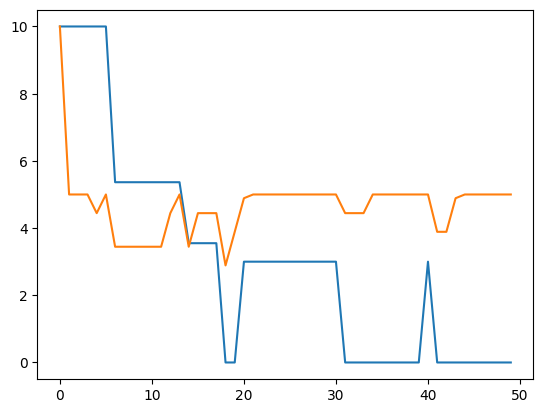

In [10]:
plt.plot(states[:, -2]) # Queue
plt.plot(states[:, -1]) # Battery

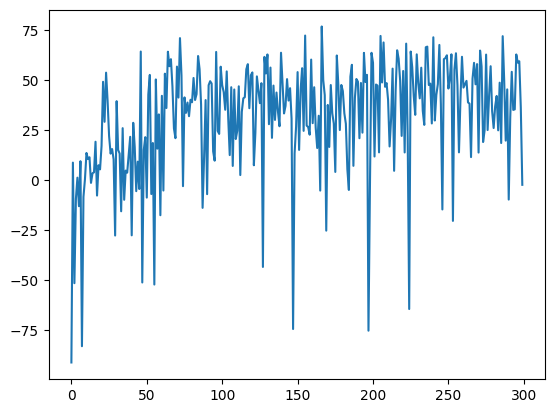

In [11]:
plt.plot(Gs)

# Multi-task

In [18]:
E = 1_000
lr = 0.02
eps = 1.0
eps_decay = 0.9999
eps_min = 0.001
k = 40

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [19]:
Q = PARAFAC(dims=[nT] + nS + nA, k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
Gs = [[] for _ in range(nT)]
for episode in range(E):
    np.random.shuffle(envs)
    for env_idx, env in enumerate(envs):
        s, _ = env.reset()
        s_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(tuple([env_idx]) + discretizer.get_state_index(sp)).unsqueeze(0)

            s_idx_train = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
            sp_idx_train = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)
            update_model(s_idx_train, sp_idx_train, a_idx, r, Q, opt, tasks=torch.tensor([env_idx]))

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)

        if episode % 10 == 0:
            G = run_test_episode(Q, env_idx)
            Gs[env_idx].append(G)
    print(f"\rEpoch: {episode} - Return: {[Gs[i][-1] for i in range(nT)]} - {eps}", end="")

Epoch: 41 - Return: [-77.89363634046671, -25.866125036879016, 15.438124319219792, 2.3620340814727223] - 0.439006454735942557

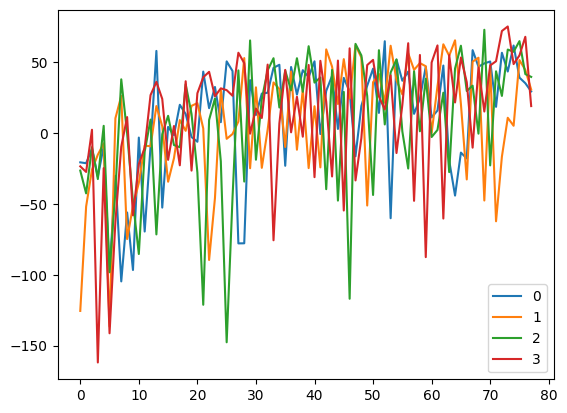

In [ ]:
plt.plot(Gs[0], label='0')
plt.plot(Gs[1], label='1')
plt.plot(Gs[2], label='2')
plt.plot(Gs[3], label='3')
plt.legend()
plt.show()

In [ ]:
GTs = [[] for _ in range(nT)]
for _ in range(200):
    for idx in range(nT):
        G = run_test_episode(Q, idx)
        GTs[idx].append(G)
print(np.mean(GTs, axis=1))

[ -10.62408257   19.47977301 -189.92022292 -154.89796562]


# Centralized

In [ ]:
E = 1_000
lr = 0.02
eps = 1.0
eps_decay = 0.9999
eps_min = 0.001
k = 40

def run_test_episode(Q, env_idx):
    with torch.no_grad():
        G = 0
        s, _ = envs[env_idx].reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a_idx = Q(s_idx).argmax().item()
            a = discretizer.get_action_from_index(a_idx)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = envs[env_idx].step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            G += r

            if d:
                break

            s = sp
            s_idx = sp_idx
    return G

In [ ]:
# SEQUENTIAL SAMPLING
Q = PARAFAC(dims=nS + nA, k=k, scale=0.1)
opt = torch.optim.Adamax(Q.parameters(), lr=lr)
Gs = [[] for _ in range(nT)]
for episode in range(E):
    np.random.shuffle(envs)
    for env_idx, env in enumerate(envs):
        s, _ = env.reset()
        s_idx = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            a_idx = torch.tensor(a_idx).unsqueeze(0)
            sp, r, d, _, _ = env.step(a)
            sp_idx = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)

            s_idx_train = torch.tensor(discretizer.get_state_index(s)).unsqueeze(0)
            sp_idx_train = torch.tensor(discretizer.get_state_index(sp)).unsqueeze(0)
            update_model(s_idx_train, sp_idx_train, a_idx, r, Q, opt, tasks=None)

            if d: 
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
        if episode % 10 == 0:
            G = run_test_episode(Q, env_idx)
            Gs[env_idx].append(G)
    print(f"\rEpoch: {episode} - Return: {[Gs[i][-1] for i in range(nT)]}", end="")

Epoch: 999 - Return: [47.84262775439684, 50.032763526640466, -4.090940862205699, 56.939418874255644]]]

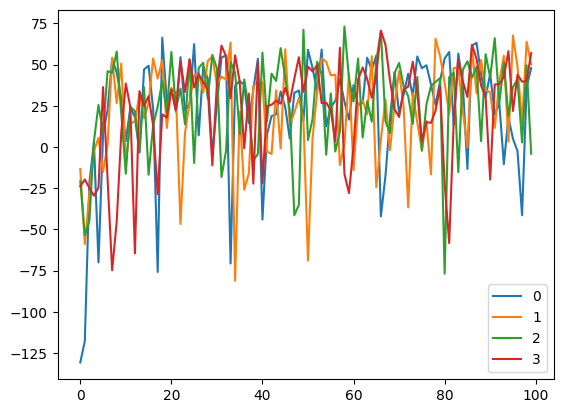

In [ ]:
plt.plot(Gs[0], label='0')
plt.plot(Gs[1], label='1')
plt.plot(Gs[2], label='2')
plt.plot(Gs[3], label='3')
plt.legend()
plt.show()

In [ ]:
GTs = [[] for _ in range(nT)]
for _ in range(200):
    for idx in range(nT):
        G = run_test_episode(Q, idx)
        GTs[idx].append(G)
print(np.mean(GTs, axis=1))

[31.70037242 47.53040604 43.23225437 44.89092963]


# Plot

In [29]:
arr_multi = np.load("results/e2_wire_multi.npy")
arr_single_all = np.load("results/e3_wire_single_all.npy")

In [34]:
#arr_single_mean = np.mean(arr_single, axis=1)
#arr_single_std = np.std(arr_single, axis=1)
#arr_single_std = np.percentile(arr_single, q=75, axis=1) - np.percentile(arr_single, q=25, axis=1)

arr_multi_mean = np.mean(arr_multi, axis=0)
arr_multi_std = np.std(arr_multi, axis=0)
#arr_multi_std = np.percentile(arr_multi, q=75, axis=0) - np.percentile(arr_multi, q=25, axis=0)

arr_single_all_mean = np.mean(arr_single_all, axis=0)
arr_single_all_std = np.std(arr_single_all, axis=0)
#arr_single_all_std = np.percentile(arr_single_all, q=75, axis=0) - np.percentile(arr_single_all, q=25, axis=0)

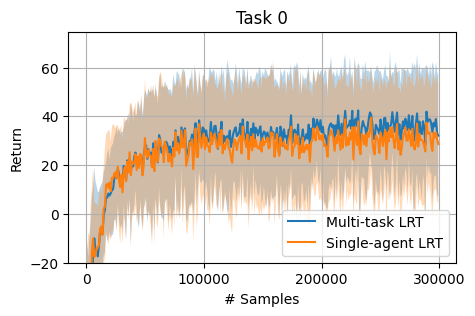

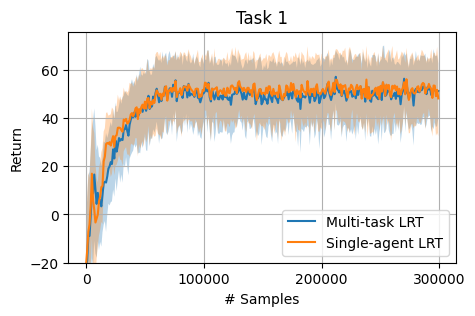

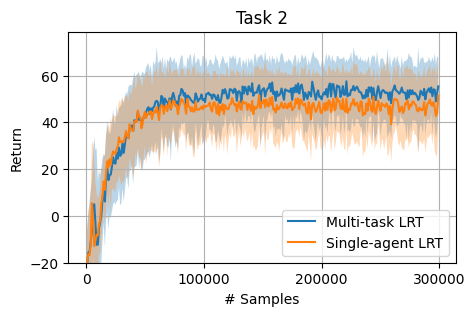

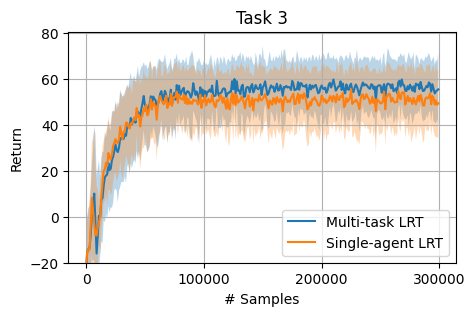

In [35]:
import numpy as np
import matplotlib.pyplot as plt


# List of matrices
#matrices = [arr_single_mean, arr_multi_mean, arr_single_all_mean]
#stds = [arr_single_std, arr_multi_std, arr_single_all_std]
#labels = ['Single-task', 'Multi-task LRT', 'Single-agent LRT']

matrices = [arr_multi_mean, arr_single_all_mean]
stds = [arr_multi_std, arr_single_all_std]
labels = ['Multi-task LRT', 'Single-agent LRT']

# Iterate over the rows (0 to 3)
for i in range(4):
    plt.figure(figsize=(5, 3))  # Create a new figure for each row
    for j, (matrix, std) in enumerate(zip(matrices, stds)):
        time = np.arange(300_000)[::1000]  # x-axis (assuming 100 time points)
        mean = matrix[i]
        std_dev = std[i]
        
        # Plot the mean
        plt.plot(time, mean, label=labels[j])
        
        # Fill the area between (mean - std) and (mean + std)
        plt.fill_between(time, mean - std_dev, mean + std_dev, alpha=0.3)
    
    plt.title(f'Task {i}')
    plt.xlabel('# Samples')
    plt.ylabel('Return')
    #plt.xlim(0, 200_000)
    plt.ylim(-20,)
    plt.xticks([0, 100_000, 200_000, 300_000])
    plt.legend()
    plt.grid()
    plt.show()
